# Predict BTC price direction - Random Forest Classifier

In [80]:
# Import libraries
import numpy as np
import pandas as pd
from pathlib import Path
import os
import requests
import datetime

from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

%matplotlib inline

In [81]:
# Read in annual coin metrics from csv
metrics_2021 = pd.read_csv('/Users/draganbogatic/Documents/Fin_Tech/crypto-analysis/resources/btc_annual_metrics/btc_metrics_1.csv', parse_dates=True)
metrics_2020 = pd.read_csv('/Users/draganbogatic/Documents/Fin_Tech/crypto-analysis/resources/btc_annual_metrics/btc_metrics_2.csv', parse_dates=True)
metrics_2019 = pd.read_csv('/Users/draganbogatic/Documents/Fin_Tech/crypto-analysis/resources/btc_annual_metrics/btc_metrics_3.csv', parse_dates=True)
metrics_2018 = pd.read_csv('/Users/draganbogatic/Documents/Fin_Tech/crypto-analysis/resources/btc_annual_metrics/btc_metrics_4.csv', parse_dates=True)
metrics_2017 = pd.read_csv('/Users/draganbogatic/Documents/Fin_Tech/crypto-analysis/resources/btc_annual_metrics/btc_metrics_5.csv', parse_dates=True)
metrics_2016 = pd.read_csv('/Users/draganbogatic/Documents/Fin_Tech/crypto-analysis/resources/btc_annual_metrics/btc_metrics_6.csv', parse_dates=True)
metrics_2015 = pd.read_csv('/Users/draganbogatic/Documents/Fin_Tech/crypto-analysis/resources/btc_annual_metrics/btc_metrics_7.csv', parse_dates=True)
metrics_2014 = pd.read_csv('/Users/draganbogatic/Documents/Fin_Tech/crypto-analysis/resources/btc_annual_metrics/btc_metrics_8.csv', parse_dates=True)
metrics_2013 = pd.read_csv('/Users/draganbogatic/Documents/Fin_Tech/crypto-analysis/resources/btc_annual_metrics/btc_metrics_9.csv', parse_dates=True)
metrics_2012 = pd.read_csv('/Users/draganbogatic/Documents/Fin_Tech/crypto-analysis/resources/btc_annual_metrics/btc_metrics_10.csv', parse_dates=True)
metrics_2011 = pd.read_csv('/Users/draganbogatic/Documents/Fin_Tech/crypto-analysis/resources/btc_annual_metrics/btc_metrics_11.csv', parse_dates=True)
metrics_2010 = pd.read_csv('/Users/draganbogatic/Documents/Fin_Tech/crypto-analysis/resources/btc_annual_metrics/btc_metrics_12.csv', parse_dates=True)
metrics_2009 = pd.read_csv('/Users/draganbogatic/Documents/Fin_Tech/crypto-analysis/resources/btc_annual_metrics/btc_metrics_13.csv', parse_dates=True)

In [82]:
# Read in combined BTC Google trends data
btc_google_trends = pd.read_csv('/Users/draganbogatic/Documents/Fin_Tech/crypto-analysis/resources/btc_google_trends/btc_trends_combined.csv', parse_dates=True)
btc_google_trends.reset_index(inplace=True)
btc_google_trends.rename(columns={'date':'time', 'bitcoin':'BTC_Trends'},inplace=True)
btc_google_trends = btc_google_trends.drop(columns='index')
btc_google_trends['time'] = pd.to_datetime(btc_google_trends['time']).dt.date
btc_google_trends = btc_google_trends.set_index('time')
btc_google_trends.tail()

,BTC_Trends
time,
2021-12-27,45
2021-12-28,45
2021-12-29,46
2021-12-30,43
2021-12-31,41


In [83]:
# Concat all csv files  and print combined csv
combined = pd.concat([metrics_2009,metrics_2010,metrics_2011,metrics_2012,metrics_2013,metrics_2014,metrics_2015,metrics_2016,metrics_2017,metrics_2018,metrics_2019,metrics_2020,metrics_2021], axis=0)
combined_df = pd.DataFrame(combined)
combined_df = combined_df.drop_duplicates(keep='first')
combined_df.tail()

,time,asset,AdrActCnt,CapMVRVCur,CapMrktCurUSD,HashRate,NVTAdj,PriceUSD,SplyCur,TxCnt,TxTfrValAdjUSD,VelCur1yr
346,2021-12-13 00:00:00+00:00,btc,996713,1.915300,8.842453e+11,1.695883e+08,69.789128,46785.327841,1.890006e+07,281785,1.267024e+10,14.525969
347,2021-12-14 00:00:00+00:00,btc,966596,1.974878,9.127791e+11,1.780076e+08,72.469440,48292.682250,1.890098e+07,281921,1.259537e+10,14.533207
348,2021-12-15 00:00:00+00:00,btc,1058257,1.995927,9.229897e+11,1.695883e+08,62.867727,48830.622386,1.890186e+07,280841,1.468146e+10,14.536127
349,2021-12-16 00:00:00+00:00,btc,873836,1.948720,9.009626e+11,1.383167e+08,56.242508,47663.469108,1.890258e+07,256019,1.601925e+10,14.533316
350,2021-12-17 00:00:00+00:00,btc,979005,1.896527,8.758845e+11,1.792104e+08,48.186258,46334.483749,1.890351e+07,260119,1.817706e+10,14.538415


In [84]:
combined_df.isnull().sum()

time                0
asset               0
AdrActCnt           0
CapMVRVCur        561
CapMrktCurUSD     561
HashRate            6
NVTAdj            260
PriceUSD          561
SplyCur             0
TxCnt               0
TxTfrValAdjUSD    561
VelCur1yr           6
dtype: int64

In [85]:
combined_df.dropna(inplace=True)
combined_df.isnull().sum()

time              0
asset             0
AdrActCnt         0
CapMVRVCur        0
CapMrktCurUSD     0
HashRate          0
NVTAdj            0
PriceUSD          0
SplyCur           0
TxCnt             0
TxTfrValAdjUSD    0
VelCur1yr         0
dtype: int64

In [86]:
# Remove timestamp in time column
combined_df['time'] = pd.to_datetime(combined_df['time']).dt.date
combined_df = combined_df.set_index('time')
combined.to_csv('resources/btc_annual_metrics/combined.csv')

In [87]:
# Concat metrics and google trends data
combined_df = pd.concat([combined_df,btc_google_trends],axis=1).dropna()
combined_df = combined_df.reset_index()
combined_df = combined_df.rename(columns={'index':'time'})
combined_df = combined_df.set_index('time')
combined_df.tail()

,asset,AdrActCnt,CapMVRVCur,CapMrktCurUSD,HashRate,NVTAdj,PriceUSD,SplyCur,TxCnt,TxTfrValAdjUSD,VelCur1yr,BTC_Trends
time,,,,,,,,,,,,
2021-12-13,btc,996713.0,1.915300,8.842453e+11,1.695883e+08,69.789128,46785.327841,1.890006e+07,281785.0,1.267024e+10,14.525969,51
2021-12-14,btc,966596.0,1.974878,9.127791e+11,1.780076e+08,72.469440,48292.682250,1.890098e+07,281921.0,1.259537e+10,14.533207,57
2021-12-15,btc,1058257.0,1.995927,9.229897e+11,1.695883e+08,62.867727,48830.622386,1.890186e+07,280841.0,1.468146e+10,14.536127,53
2021-12-16,btc,873836.0,1.948720,9.009626e+11,1.383167e+08,56.242508,47663.469108,1.890258e+07,256019.0,1.601925e+10,14.533316,48
2021-12-17,btc,979005.0,1.896527,8.758845e+11,1.792104e+08,48.186258,46334.483749,1.890351e+07,260119.0,1.817706e+10,14.538415,49


In [88]:
# Read in Relative Strength(RSI) data
rsi_btc = pd.read_csv('/Users/draganbogatic/Documents/Fin_Tech/crypto-analysis/resources/rsi_btc.csv', parse_dates=True, index_col='time')
rsi_btc.tail()

,RSI_14
time,
2021-12-13,33.164148
2021-12-14,37.885222
2021-12-15,39.526932
2021-12-16,37.227881
2021-12-17,34.749431


In [89]:
# Read in Rate of Change (ROC) data
roc_btc = pd.read_csv('/Users/draganbogatic/Documents/Fin_Tech/crypto-analysis/resources/roc_btc.csv', parse_dates=True, index_col='time')
roc_btc.tail()

,ROC_14
time,
2021-12-13,-19.225218
2021-12-14,-15.419950
2021-12-15,-14.602830
2021-12-16,-15.763465
2021-12-17,-13.670414


In [90]:
# Read in Money Flow Index (MFI) data
mfi_btc = pd.read_csv('/Users/draganbogatic/Documents/Fin_Tech/crypto-analysis/resources/mfi_btc.csv', parse_dates=True)
mfi_btc = mfi_btc.rename(columns={'Date':'time'})
mfi_btc['time'] = pd.to_datetime(mfi_btc['time']).dt.date
mfi_btc = mfi_btc.set_index('time').dropna()
mfi_btc.tail()

,MFI_14
time,
2022-01-05,39.022610
2022-01-06,31.982329
2022-01-07,22.902815
2022-01-08,22.691290
2022-01-09,26.965353


In [91]:
# Read in True Strength (TSI) data
tsi_btc = pd.read_csv('/Users/draganbogatic/Documents/Fin_Tech/crypto-analysis/resources/tsi_btc.csv', parse_dates=True)
tsi_btc = tsi_btc.rename(columns={'Date':'time'})
tsi_btc['time'] = pd.to_datetime(tsi_btc['time']).dt.date
tsi_btc = tsi_btc.set_index('time').dropna()
tsi_btc.tail()

,TSI_13_25_13,TSIs_13_25_13
time,,
2021-12-13,-28.461637,-22.250541
2021-12-14,-27.879649,-23.054700
2021-12-15,-26.909529,-23.605390
2021-12-16,-26.771374,-24.057673
2021-12-17,-27.390082,-24.533731


In [92]:
# Create model features dataframe
features_btc = pd.concat([combined_df,rsi_btc, roc_btc, mfi_btc,tsi_btc], axis=1)
features_btc.head()

,asset,AdrActCnt,CapMVRVCur,CapMrktCurUSD,HashRate,NVTAdj,PriceUSD,SplyCur,TxCnt,TxTfrValAdjUSD,VelCur1yr,BTC_Trends,RSI_14,ROC_14,MFI_14,TSI_13_25_13,TSIs_13_25_13
time,,,,,,,,,,,,,,,,,
2010-07-18,btc,860.0,146.038332,295959.152000,0.001552,200.680421,0.085840,3447800.0,248.0,1474.778412,1.820565,0.0,NaN,NaN,NaN,NaN,NaN
2010-07-19,btc,929.0,62.565130,279285.200000,0.001570,85.889156,0.080800,3456500.0,334.0,3251.693384,1.828863,0.0,NaN,NaN,NaN,NaN,NaN
2010-07-20,btc,936.0,45.106630,259000.404990,0.001633,215.744281,0.074736,3465550.0,423.0,1200.497201,1.831412,17.0,NaN,NaN,NaN,NaN,NaN
2010-07-21,btc,784.0,38.357560,275266.471297,0.001868,166.836660,0.079193,3475900.0,247.0,1649.915979,1.833749,34.0,NaN,NaN,NaN,NaN,NaN
2010-07-22,btc,594.0,25.132348,203749.573975,0.001588,105.440311,0.058470,3484700.0,221.0,1932.368865,1.840245,0.0,NaN,NaN,NaN,NaN,NaN


<AxesSubplot:title={'center':'EMA BTC'}, xlabel='time', ylabel='BTC Price ($)'>

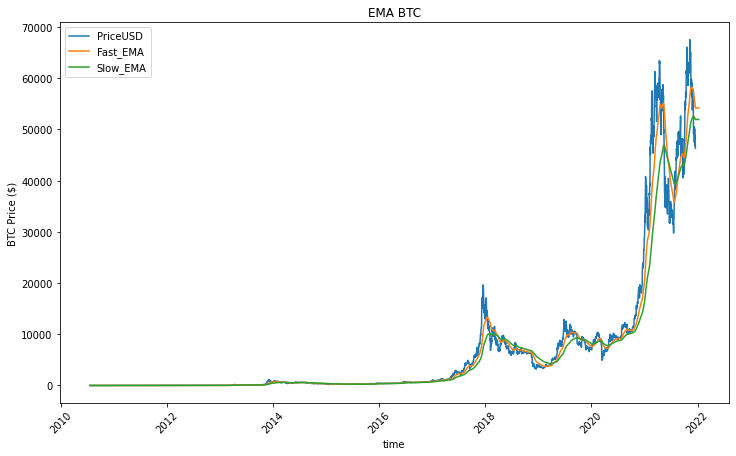

In [93]:
# Set short and long windows for EMA (Exponential Moving Average) to create trading signals features
short_window = 20
long_window = 50

# Construct a `Fast` and `Slow` Exponential Moving Average from short and long windows, respectively
features_btc['Fast_EMA'] = features_btc['PriceUSD'].ewm(halflife=short_window).mean()
features_btc['Slow_EMA'] = features_btc['PriceUSD'].ewm(halflife=long_window).mean()

# Plot the EMA of ETH closing prices
features_btc[['PriceUSD', 'Fast_EMA', 'Slow_EMA']].plot(figsize=(12,7), title='EMA BTC', ylabel='BTC Price ($)', rot=45) 

In [94]:
# Construct a crossover trading signal
features_btc['Crossover_Long'] = np.where(features_btc['Fast_EMA'] > features_btc['Slow_EMA'], 1.0, 0.0)
features_btc['Crossover_Short'] = np.where(features_btc['Fast_EMA'] < features_btc['Slow_EMA'],-1.0, 0.0)
features_btc['Crossover_Signal'] = features_btc['Crossover_Long'] + features_btc['Crossover_Short']

In [95]:
# Calculate daily return
features_btc['Daily_Return'] = features_btc['PriceUSD'].pct_change()

In [96]:
# Construct the dependent variable where if daily return is greater than 0, then 1, else, 0.
features_btc['Positive_Return'] = np.where(features_btc['Daily_Return'] > 0, 1.0, 0.0)

features_btc = features_btc.dropna()

# Convert date to str to set test and train windows 
features_btc.index = pd.to_datetime(features_btc.index, format = '%Y/%m/%d')
features_btc.tail()
features_btc.to_csv('/Users/draganbogatic/Documents/Fin_Tech/crypto-analysis/resources/features_btc.csv')

In [97]:
# Select model features and timeframe for train data
X = features_btc[['AdrActCnt','CapMrktCurUSD','CapMVRVCur','HashRate','NVTAdj','TxCnt','TxTfrValAdjUSD','VelCur1yr','Crossover_Signal','BTC_Trends','RSI_14','ROC_14','MFI_14','TSI_13_25_13','TSIs_13_25_13']]
X_train = X[:'2020']

In [98]:
# Select prediction variable and timeframe for train data
y = features_btc['Positive_Return']
y_train = y[:'2020']

In [99]:
# Define timeframe for testing data
X_test = X['2021':]
y_test = y['2021':]

In [100]:
# Create the StandardScaler instance
scaler = StandardScaler()

In [101]:
# Fit the Standard Scaler with the training data
X_scaler = scaler.fit(X_train)

In [102]:
# Scale the training data
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

In [104]:
# Perform the grid search for the optimal set of tree parameters
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV

n_estimators = [20,500]
max_depth= [5,10]
num_folds = 10
scoring = 'accuracy'

criterion = ["gini","entropy"]
param_grid = dict(n_estimators=n_estimators, max_depth=max_depth, \
  criterion = criterion )

model = RandomForestClassifier(n_jobs=-1)

kfold = KFold(n_splits=num_folds, random_state=None)
grid = GridSearchCV(estimator=model, param_grid=param_grid, \
  scoring=scoring, cv=kfold)
grid_result = grid.fit(X_train, y_train)
print("Best: %f using %s" % (grid_result.best_score_,\
  grid_result.best_params_))

Best: 0.638822 using {'criterion': 'entropy', 'max_depth': 10, 'n_estimators': 500}


In [105]:
# Define the model using optimized settings (also use if you want to run without optimizer above)
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV

model = RandomForestClassifier(n_jobs=-1)
model = RandomForestClassifier(criterion='entropy', max_depth=10, n_estimators=500, n_jobs=-1)

In [106]:
# Fit the model
model = model.fit(X_train_scaled, y_train)

In [107]:
# Making predictions using the testing data
predictions = model.predict(X_test_scaled)

In [108]:
# Calculating the confusion matrix
cm = confusion_matrix(y_test, predictions)
cm_df = pd.DataFrame(cm, index=["Actual 0", "Actual 1"], columns=["Predicted 0", "Predicted 1"])

# Calculating the accuracy score
acc_score = accuracy_score(y_test, predictions)

In [109]:
# Displaying results
print("Confusion Matrix")
display(cm_df)
print(f"Accuracy Score : {acc_score}")
print("Classification Report")
print(classification_report(y_test, predictions))

Confusion Matrix


,Predicted 0,Predicted 1
Actual 0,55,109
Actual 1,24,163


Accuracy Score : 0.6210826210826211
Classification Report
              precision    recall  f1-score   support

         0.0       0.70      0.34      0.45       164
         1.0       0.60      0.87      0.71       187

    accuracy                           0.62       351
   macro avg       0.65      0.60      0.58       351
weighted avg       0.64      0.62      0.59       351



In [110]:
# Assemble actual y data (Y_test) with predicted y data (from just above) into two columns in a dataframe
Results = y_test.to_frame()
Results["Predicted Value"] = predictions
Results[-20:]

,Positive_Return,Predicted Value
time,,
2021-11-28,1.0,1.0
2021-11-29,1.0,1.0
2021-11-30,0.0,1.0
2021-12-01,1.0,1.0
2021-12-02,0.0,1.0
2021-12-03,0.0,1.0
2021-12-04,0.0,0.0
2021-12-05,1.0,0.0
2021-12-06,1.0,1.0


In [111]:
# List the features sorted in descending order by feature importance
importances = model.feature_importances_
sorted(zip(model.feature_importances_, X.columns), reverse=True)

[(0.17653876154824996, 'RSI_14'),
 (0.10097320204112406, 'TSI_13_25_13'),
 (0.08467162342406195, 'ROC_14'),
 (0.07457105605745115, 'MFI_14'),
 (0.06945821484599494, 'TSIs_13_25_13'),
 (0.0618169008942645, 'NVTAdj'),
 (0.058618096403954996, 'CapMVRVCur'),
 (0.057746744080827014, 'AdrActCnt'),
 (0.05685844460202722, 'TxCnt'),
 (0.05427455631809937, 'TxTfrValAdjUSD'),
 (0.05253874522611747, 'CapMrktCurUSD'),
 (0.05240636138001716, 'HashRate'),
 (0.05008354983081695, 'VelCur1yr'),
 (0.04654817969619711, 'BTC_Trends'),
 (0.0028955636507959582, 'Crossover_Signal')]

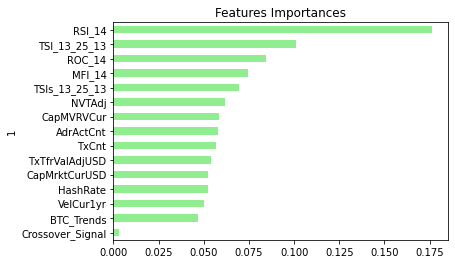

In [112]:
# Visualize the features by importance
importances_df = pd.DataFrame(sorted(zip(model.feature_importances_,    X.columns), reverse=True))
importances_df.set_index(importances_df[1], inplace=True)
importances_df.drop(columns=1, inplace=True)
importances_df.rename(columns={0: 'Feature Importances'}, inplace=True)

importances_sorted = importances_df.sort_values(by=
'Feature Importances')

importances_plot = importances_sorted.plot(kind='barh', color='lightgreen', title='Features Importances', legend=False)

In [60]:
# RSI is the most dominant feature which shows that BTC price is primarily determined by momentum.

## Prediction Lagged Data

In [113]:
features_btc = features_btc[['RSI_14','ROC_14','TSI_13_25_13','TSIs_13_25_13', 'Positive_Return']]
features_btc['Lagged_Pos_Ret'] = features_btc['Positive_Return'].shift(1)
features_btc.head()

,RSI_14,ROC_14,TSI_13_25_13,TSIs_13_25_13,Positive_Return,Lagged_Pos_Ret
time,,,,,,
2014-10-01,33.968761,-16.091191,-34.299001,-33.803511,0.0,NaN
2014-10-02,31.742875,-12.732945,-34.658769,-33.925691,0.0,0.0
2014-10-03,28.831228,-9.197446,-35.892793,-34.206706,0.0,0.0
2014-10-04,24.193128,-20.001694,-38.614390,-34.836375,0.0,0.0
2014-10-05,23.351486,-19.374973,-41.043432,-35.723097,0.0,0.0


In [114]:
features_btc = features_btc.dropna()

In [115]:
# Select model features and timeframe for train data
X = features_btc[['RSI_14','ROC_14','TSI_13_25_13','TSIs_13_25_13']]
X_train = X[:'2020']

In [116]:
# Select prediction variable and timeframe for train data
y = features_btc['Lagged_Pos_Ret']
y_train = y[:'2020']

In [117]:
# Define timeframe for testing data
X_test = X['2021':]
y_test = y['2021':]

In [118]:
# Create the StandardScaler instance
scaler = StandardScaler()
# Fit the Standard Scaler with the training data
X_scaler = scaler.fit(X_train)
# Scale the training data
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

In [119]:
# Define the model using optimized settings (also use if you want to run without optimizer above)
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(n_jobs=-1)
model = RandomForestClassifier(criterion='entropy', max_depth=10, n_estimators=500, n_jobs=-1)

In [120]:
# Fit the model
model = model.fit(X_train_scaled, y_train)
# Making predictions using the testing data
predictions = model.predict(X_test_scaled)
# Calculating the confusion matrix
cm = confusion_matrix(y_test, predictions)
cm_df = pd.DataFrame(cm, index=["Actual 0", "Actual 1"], columns=["Predicted 0", "Predicted 1"])
# Calculating the accuracy score
acc_score = accuracy_score(y_test, predictions)
# Displaying results
print("Confusion Matrix")
display(cm_df)
print(f"Accuracy Score : {acc_score}")
print("Classification Report")
print(classification_report(y_test, predictions))

Confusion Matrix


,Predicted 0,Predicted 1
Actual 0,87,76
Actual 1,55,133


Accuracy Score : 0.6267806267806267
Classification Report
              precision    recall  f1-score   support

         0.0       0.61      0.53      0.57       163
         1.0       0.64      0.71      0.67       188

    accuracy                           0.63       351
   macro avg       0.62      0.62      0.62       351
weighted avg       0.63      0.63      0.62       351



In [121]:
# Assemble actual y data (Y_test) with predicted y data (from just above) into two columns in a dataframe
Results = y_test.to_frame()
Results["Predicted Value"] = predictions
Results[-20:]

,Lagged_Pos_Ret,Predicted Value
time,,
2021-11-28,1.0,1.0
2021-11-29,1.0,1.0
2021-11-30,1.0,1.0
2021-12-01,0.0,1.0
2021-12-02,1.0,0.0
2021-12-03,0.0,0.0
2021-12-04,0.0,0.0
2021-12-05,0.0,0.0
2021-12-06,1.0,0.0
